In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [3]:
# REMARK: There are no spherical TOKAMAKs in these analyses.  

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv(path+"new_point_ids.csv")
                  
R = pd.read_csv(path+"R.csv") #DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

reg_data = pd.read_csv(path+"data.csv")

In [4]:
def get_regression_np(_R):
    data = pd.concat([DB2, _R],
                     axis=0, 
                     ignore_index=True
                    )
    Y_ = data[["TAUTH"]].to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs]; _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

# Getting regression of DB2P8 only. 
regression_DB2 = get_regression_np(R[R.id.isin([0])])[1]
#regression_DB2.summary()

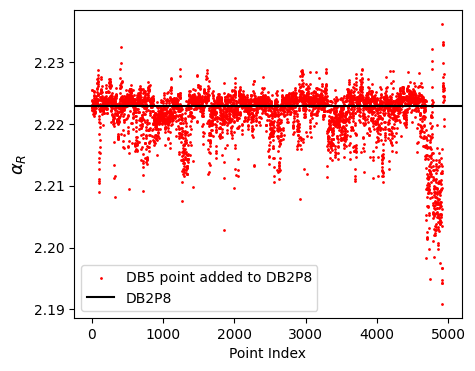

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(reg_data.index, reg_data.αR, s=1, c="r", label="DB5 point added to DB2P8")
plt.axhline(regression_DB2.params[5], c="k", label="DB2P8")
plt.xlabel("Point Index")
plt.ylabel("$\\alpha_R$", fontsize=13)
plt.legend();

In [6]:
# Leave the ones above baseline out -- because we are interested in the reduction of value
pts_minimize = reg_data[reg_data.αR < regression_DB2.params[5] ]
pts_minimize = pts_minimize.sort_values("αR", ascending=True)


# Ordering dataset ids from smallest to greatest alpha-R 

dict_ordered_vals = dict(zip( 
    pts_minimize.id_added.values, 
    list(range(len(pts_minimize)))  
) )

DB5_decreas_pts = R[R.id.isin(pts_minimize.id_added)]
DB5_decreas_pts.insert(0, "ordered", DB5_decreas_pts.id.map(dict_ordered_vals))

DB5_decreas_pts = DB5_decreas_pts.sort_values("ordered")
DB5_decreas_pts = DB5_decreas_pts.set_index("ordered")

In [7]:
reg_coeff_per_pts = np.zeros(len(pts_minimize))
for i in range(1, len(pts_minimize) + 1):
    # Adding one point at a time to DB2P8 from DB5 od decreasing subset in an ordered manner.
    R_ = (DB5_decreas_pts.iloc[:i][["TAUTH"] + coeffs])
    # Storing regression coefficient for alpha_R only
    reg_coeff_per_pts[i-1] = get_regression_np(R_)[1].params[5]
    
DB5_decreas_pts["αR_per_pts_in_DB2"] = reg_coeff_per_pts

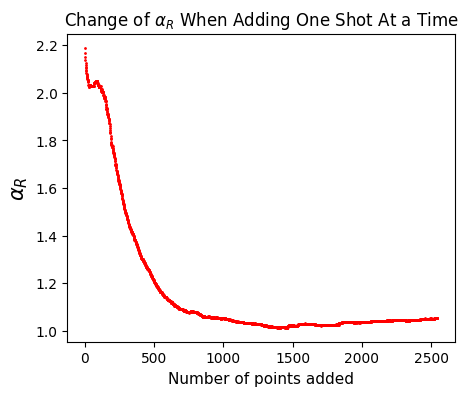

In [8]:
#%matplotlib notebook

plt.figure(figsize=(5,4))
plt.scatter(DB5_decreas_pts.index + 1, DB5_decreas_pts["αR_per_pts_in_DB2"], s=1, c = "r")
plt.xlabel("Number of points added", fontsize=11)
plt.ylabel("$\\alpha_R$", fontsize=15)
plt.title("Change of $\\alpha_R$ When Adding One Shot At a Time");

In [9]:
# Labeling shots that decreased or increased the overall regression when added
df = DB5_decreas_pts[["αR_per_pts_in_DB2"]]
df.insert(0, "prev_val", [regression_DB2.params[5]] + list(df["αR_per_pts_in_DB2"].iloc[:-1].values))
df.insert(0, "difference", df["αR_per_pts_in_DB2"] - df["prev_val"])
DB5_decreas_pts.insert(0, "decreased", df.difference.apply(lambda x: 1 if x<=0 else 0))
DB5_decreas_pts.insert(0, "weights", DB5_decreas_pts.decreased.values/len(DB5_decreas_pts) + 1 )

In [10]:
num_samples = 5


max_amount = len( DB5_decreas_pts ) + 1
SAMPLES = np.zeros((num_samples, max_amount - 1))

for i in range(num_samples):
    for j in range(1, max_amount):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='weights', random_state=71*(i + 3))
        SAMPLES[i,j-1] = get_regression_np(R_sampled)[1].params[5]

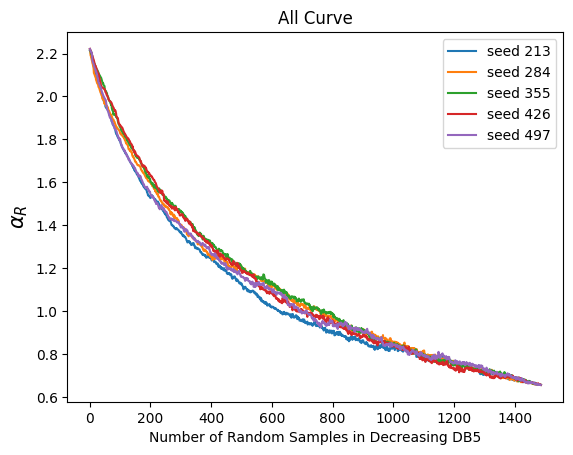

In [19]:
for s in range(num_samples):
    plt.plot(range(1, max_amount), SAMPLES[s,], label=f'seed {71*(s + 3)}')
plt.legend()
plt.title("All Curve")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15);

In [12]:
for s in range(num_samples):
    print( min(SAMPLES[s,]), np.argmin(SAMPLES[s,]))

1.047692850846871 2385
1.0469016563959335 2507
1.0504337866203382 2441
1.0521250138652025 2535
1.0452796614160078 2516


In [13]:
max_amount = len( DB5_decreas_pts[DB5_decreas_pts.decreased.isin([1])] ) + 1
SAMPLES = np.zeros((num_samples, max_amount - 1))

for i in range(num_samples):
    for j in range(1, max_amount):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='decreased', random_state=71*(i + 3))
        SAMPLES[i,j-1] = get_regression_np(R_sampled)[1].params[5]

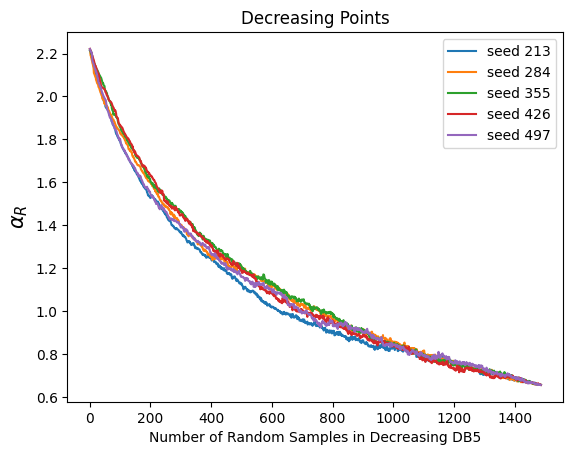

In [21]:
for s in range(num_samples):
    plt.plot(range(1,max_amount), SAMPLES[s,], label=f'seed {71*(s + 3)}')
plt.legend()
plt.title("Decreasing Points")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15);

In [15]:
for s in range(num_samples):
    print( min(SAMPLES[s,]), np.argmin(SAMPLES[s,]))

0.6558006008429031 1485
0.6558006008429019 1485
0.6558006008429 1485
0.6558006008429005 1485
0.6555141955179472 1479


## Close-Up Analyses